In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import rlway.osrd.infra as infr

In [15]:
infra, simulation, result = infr.read_jsons_in_dir('../cases/2cvg')

In [16]:
infr.draw_infra(infra)

In [23]:
cvg_signals = infr.convergence_entry_signals(infra)
cvg_signals

['SA1', 'SA2', 'S4', 'SC1']

In [52]:
infr.points_on_track_sections(infra)

{'WEST_Q1': {'WEST_Q1_BEGIN': (0, 'begin'),
  'Station_WEST': (400.0, 'station'),
  'SA1': (410.0, 'cvg_signal'),
  'DA1': (430.0, 'detector'),
  'WEST_Q1_END': (450.0, 'end')},
 'WEST_Q2': {'WEST_Q2_BEGIN': (0, 'begin'),
  'Station_WEST': (400.0, 'station'),
  'SA2': (410.0, 'cvg_signal'),
  'DA2': (430.0, 'detector'),
  'WEST_Q2_END': (450.0, 'end')},
 'T1': {'T1_BEGIN': (0, 'begin'),
  'SA3': (30.0, 'signal'),
  'DA_out': (50.0, 'detector'),
  'S0': (1960.0, 'signal'),
  'D0': (1980.0, 'detector'),
  'S1': (3940.0, 'signal'),
  'D1': (3960.0, 'detector'),
  'S2': (5920.0, 'signal'),
  'D2': (5940.0, 'detector'),
  'S3': (7900.0, 'signal'),
  'D3': (7920.0, 'detector'),
  'S4': (9880.0, 'cvg_signal'),
  'D4': (9900.0, 'detector'),
  'T1_END': (10000.0, 'end')},
 'T2': {'T2_BEGIN': (0, 'begin'),
  'S5': (1960.0, 'signal'),
  'D5': (1980.0, 'detector'),
  'S6': (3940.0, 'signal'),
  'D6': (3960.0, 'detector'),
  'S7': (5920.0, 'signal'),
  'D7': (5940.0, 'detector'),
  'S8': (7900.0, '

In [39]:
import rlway.osrd.result as res

points = []

for ts in res.train_track_sections(result, 0):
    points += [
        point
        for point, (position, tag) in infr.points_on_track_sections(infra)[ts].items()
        if tag in ['station', 'cvg_signal']
    ]

In [76]:
res.points_encountered_by_train(infra, result, 0,)
res.points_encountered_by_train(infra, result, 1, ['station', 'cvg_signal'])

[('Station_SOUTH', 'SOUTH_Q1', 400.0, 'station'),
 ('SC1', 'SOUTH_Q1', 410.0, 'cvg_signal'),
 ('Station_EAST', 'EAST_Q2', 10850.0, 'station')]

In [83]:
result[1]['base_simulations'][0]

{'head_positions': [{'offset': 400.0,
   'path_offset': 0.0,
   'time': 0.0,
   'track_section': 'SOUTH_Q1'},
  {'offset': 403.6877089403523,
   'path_offset': 3.6877089403523287,
   'time': 4.0,
   'track_section': 'SOUTH_Q1'},
  {'offset': 423.01636855729333,
   'path_offset': 23.01636855729334,
   'time': 10.0,
   'track_section': 'SOUTH_Q1'},
  {'offset': 445.0655840853055,
   'path_offset': 45.065584085305474,
   'time': 14.0,
   'track_section': 'SOUTH_Q1'},
  {'offset': 41.806943648718715,
   'path_offset': 91.80694364871871,
   'time': 20.0,
   'track_section': 'T2'},
  {'offset': 82.02578194409776,
   'path_offset': 132.02578194409776,
   'time': 24.0,
   'track_section': 'T2'},
  {'offset': 155.8111505355178,
   'path_offset': 205.8111505355178,
   'time': 30.0,
   'track_section': 'T2'},
  {'offset': 213.87671506148,
   'path_offset': 263.87671506148,
   'time': 34.0,
   'track_section': 'T2'},
  {'offset': 314.0010855583903,
   'path_offset': 364.0010855583903,
   'time': 4

In [96]:
import numpy as np

records_min = result[1]['base_simulations'][0]['head_positions']
offset = records_min[0]['offset']
offsets_min = [offset + t['path_offset'] for t in records_min]
times_min = [t['time'] for t in records_min]

records_eco = result[1]['eco_simulations'][0]['head_positions']
offset = records_eco[0]['offset']
offsets_eco = [offset + t['path_offset'] for t in records_eco]
times_eco = [t['time'] for t in records_eco]

In [122]:
res.points_encountered_by_train(infra, result, 1)
points = res.points_encountered_by_train(infra, result, 1)

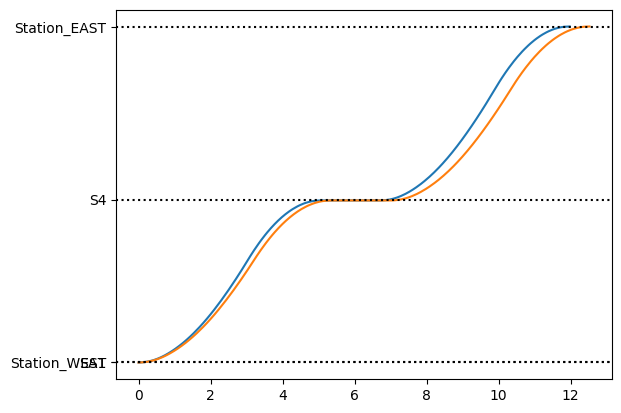

In [134]:
import matplotlib.pyplot as plt

train = 0

points = res.points_encountered_by_train(infra, result, train, ['station', 'cvg_signal'])

records_min = result[train]['base_simulations'][0]['head_positions']
offset = records_min[0]['offset']
offsets_min = [offset + t['path_offset'] for t in records_min]
times_min = [t['time']/60 for t in records_min]

records_eco = result[train]['eco_simulations'][0]['head_positions']
offset = records_eco[0]['offset']
offsets_eco = [offset + t['path_offset'] for t in records_eco]
times_eco = [t['time']/60 for t in records_eco]

plt.plot(
    times_min,
    offsets_min,
    times_eco,
    offsets_eco
)
for point in points:
    plt.axhline(point['offset'], color='k', linestyle=':');

plt.yticks(
    [point['offset'] for point in points],
    [point['id'] for point in points]
);

<Axes: title={'center': 'train0 (base)'}>

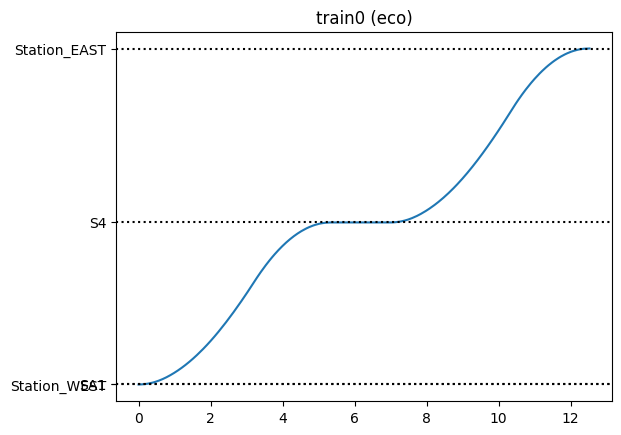

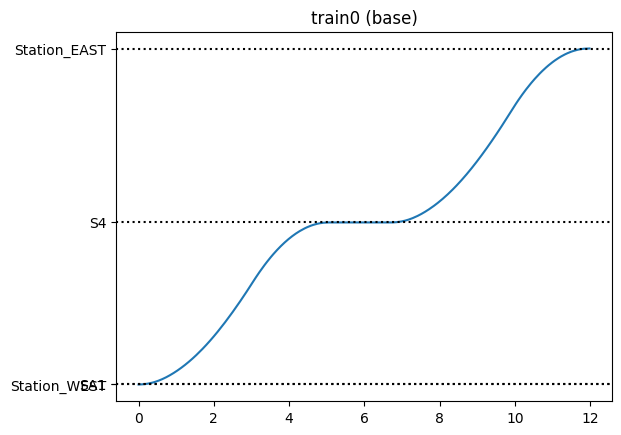

In [146]:
res.space_time_graph(infra, simulation, result, 0)
res.space_time_graph(infra, simulation, result, 0, 'base')

['train0', 'train1', 'train0']

In [ ]:
import networkx as nx

def draw_digraph(G):
    for layer, nodes in enumerate(nx.topological_generations(G)):
        # `multipartite_layout` expects the layer as a node attribute,
        # so add the numeric layer value as a node attribute
        for node in nodes:
            G.nodes[node]["layer"] = layer

    # Compute the multipartite_layout using the "layer" node attribute
    pos = nx.multipartite_layout(G, subset_key="layer")

    # _, ax = plt.subplots()
    nx.draw_networkx(G, pos, node_shape='s', )  # ax=ax)

In [68]:
lengths = [
    infr.track_section_lengths(infra)[ts]
    for ts in res.train_track_sections(result, 0)
]

offsets = [
    sum(lengths[: i]) for i, length in enumerate(lengths)
]

offsets

[0, 450.0, 10450.0, 20450.0]